In [23]:
import tensorflow as tf
import numpy as np

def get_Mtrx_and_H0(graph):
    H0 = tf.constant(graph['nodes_feature'])
    A = tf.SparseTensor(indices=np.transpose(graph["A"]),
                    values=np.array([v + 0 if index[0] != index[1] else 1
                                     for v, index in zip(graph["edges_feature"], np.transpose(graph["A"]))], dtype=np.float32), 
                    dense_shape=[max(graph["A"][0])+1, max(graph["A"][1])+1])
    d = tf.sparse.reduce_sum(A, axis=1)
    Mtrx = tf.SparseTensor(indices=np.transpose(graph["A"]),
                    values=np.array([v/d[index[0]] for index, v in zip(A.indices, A.values)], dtype=np.float32), 
                    dense_shape=[max(graph["A"][0])+1, max(graph["A"][1])+1])
    
    
    return Mtrx, tf.linalg.normalize(H0, axis=0)[0]

In [24]:
import json
with open("graph.json", "r") as f:
    graph = json.load(f)

In [25]:


    

class GraphSegmenter(tf.Module):
    def __init__(self):
        self.W = tf.Variable(tf.random.uniform(shape=[8, 10]))
        self.activation =  tf.nn.relu

    def __call__(self, graph):
        A, H0 = get_Mtrx_and_H0(graph)
        H1 = self.activation(
            tf.matmul(tf.sparse.sparse_dense_matmul(A, H0), self.W)
        )
        
        return tf.reduce_max(H1, axis=1)

def my_loss(H1_emb, H1_true):
    return tf.reduce_sum(tf.pow(H1_emb-H1_true, 2))

In [26]:
Mtrx, H0 = get_Mtrx_and_H0(graph)

In [27]:
model = GraphSegmenter()

In [28]:
model(graph)

<tf.Tensor: shape=(226,), dtype=float32, numpy=
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan,

In [29]:
with tf.GradientTape() as tape:
    h1 = model(graph)
    loss = my_loss(h1, tf.eye(num_rows=629, num_columns=1))

tape.gradient(loss, model.trainable_variables)

(<tf.Tensor: shape=(8, 10), dtype=float32, numpy=
 array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]], dtype=float32)>,)

# Вторая модель

In [30]:
with open("claster.json", "r") as f:
    clust = json.load(f)

In [31]:
clus = tf.constant(np.array(clust["clus"]), dtype=tf.dtypes.float32)

In [32]:
class GraphSegmenter2(tf.Module):
    def __init__(self):
        self.W = tf.Variable(tf.random.uniform(shape=[8, 10]))
        self.W2 = tf.Variable(tf.random.uniform(shape=[8, 10]))
        self.activation =  tf.nn.relu

    def __call__(self, graph):
        A, H0 = get_Mtrx_and_H0(graph)
        HL = tf.matmul(tf.sparse.sparse_dense_matmul(A, H0), self.W)
        HR = tf.matmul(tf.sparse.sparse_dense_matmul(A, H0), self.W2)
        H1 = self.activation(
            tf.matmul(HL, tf.transpose(HR))
        )
        
        return self.activation(H1)

def my_loss(H1_emb, H1_true):
    v1 = H1_emb
    E = tf.eye(H1_true.dense_shape[0])
    v2 = tf.sparse.sparse_dense_matmul(H1_true, E)
    return tf.reduce_sum(tf.pow(v1-v2, 2))

model2 = GraphSegmenter2()

In [33]:
opt = tf.optimizers.Adam(learning_rate=1.0)
for i in range(50):
    with tf.GradientTape() as tape:
        h1 = model2(graph)
        A, _ = get_Mtrx_and_H0(graph)
        loss = my_loss(h1, A)
    
    dW = tape.gradient(loss, model2.trainable_variables)
    opt.apply_gradients(zip(dW, model2.trainable_variables))

In [34]:
r = model2(graph)
my_loss(r, A)

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

In [35]:
with open("graph2.json", "r") as f:
    graph2 = json.load(f)

In [36]:
model2(graph2)

<tf.Tensor: shape=(677, 677), dtype=float32, numpy=
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)>

In [37]:
Mtrx, H = get_Mtrx_and_H0(graph)
tf.reduce_max(tf.matmul(tf.sparse.sparse_dense_matmul(Mtrx, H), model2.W), axis=1)

<tf.Tensor: shape=(226,), dtype=float32, numpy=
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan,

In [38]:
my_loss(model2(graph), clus)

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'dense_shape'

In [222]:
model2.W

<tf.Variable 'Variable:0' shape=(8, 10) dtype=float32, numpy=
array([[-0.02255897, -0.56373805, -0.23667705, -0.8764673 , -0.0881488 ,
        -0.3762294 ,  0.0786975 , -0.18443012, -0.15318154,  0.04701867],
       [-0.6550233 , -0.2920421 , -0.30421278, -0.16217552, -0.21856076,
        -0.48982003, -0.46877077, -0.45550892, -0.2948032 , -0.4763935 ],
       [ 0.91928804,  0.72769976,  0.8187083 ,  0.13691568,  0.7385869 ,
         0.21124876,  0.08000433,  0.8234364 ,  0.24758875,  0.36636245],
       [ 0.6141236 ,  0.50068104,  0.3811555 ,  0.02555716,  0.45479774,
         0.49741292,  0.37239134,  0.04489887,  0.87694824,  0.19765425],
       [ 0.21644545,  0.3949932 ,  0.5916754 ,  0.8857025 ,  0.18231559,
         0.06700742,  0.02315974,  0.931944  ,  0.49277127,  0.37972426],
       [ 0.72347534,  0.91455245,  0.81568813,  0.68924546,  0.23569977,
         0.6623441 ,  0.11481607,  0.41421223,  0.75635934,  0.8727002 ],
       [ 0.47485054,  0.2408818 ,  0.1656326 ,  0.583086

# Третья модель

In [39]:

params = {
    "learning_rate": 0.1,
    "start_w": 0.1,
    "start_b": 1.0,
    "weight_loss": 0.95,
    "count_neuron_layer_1": 3,
    "count_neuron_layer_2": 5,
    "count_neuron_layer_end": 9,
    "epochs": 20
}

In [40]:
def get_Mtrx_and_H0(graph):
    v = np.array(graph['nodes_feature'], dtype=np.float32)
    max_ = np.max(v, axis=0)
    min_ = np.min(v, axis=0)
    delta_ = max_- min_
    for i in range(len(v[0])):
        v[:, i] = (max_[i] - v[:, i])/delta_[i] if delta_[i] != 0 else v[:, i]
    H0 = tf.constant(v[:, [0, 1, -1]])
    A = tf.SparseTensor(indices=np.transpose(graph["A"]),
                    values=np.array([v + 0 if index[0] != index[1] else 1
                                     for v, index in zip(graph["edges_feature"], np.transpose(graph["A"]))], dtype=np.float32), 
                    dense_shape=[max(graph["A"][0])+1, max(graph["A"][1])+1])
    d = tf.sparse.reduce_sum(A, axis=1)
    Mtrx = tf.SparseTensor(indices=np.transpose(graph["A"]),
                    values=np.array([v/d[index[0]] for index, v in zip(A.indices, A.values)], dtype=np.float32), 
                    dense_shape=[max(graph["A"][0])+1, max(graph["A"][1])+1])
    

    return Mtrx, H0

class MyEndLayer(tf.Module):
    def __call__(self, graph, h):
        s1 = tf.SparseTensor(indices=[[i, e0] for i, e0 in enumerate(graph["A"][0])],
                    values=np.ones_like(graph["A"][0], dtype=np.float32), 
                    dense_shape=[len(graph["A"][0]), max(graph["A"][0])+1])
        s2 = tf.SparseTensor(indices=[[i, e1] for i, e1 in enumerate(graph["A"][1])],
                    values=np.ones_like(graph["A"][0], dtype=np.float32), 
                    dense_shape=[len(graph["A"][0]), max(graph["A"][0])+1])
        left_ = tf.sparse.sparse_dense_matmul(s1, h)
        right_ = tf.sparse.sparse_dense_matmul(s2, h)
        return 0.5*(1-tf.losses.cosine_similarity(left_ , right_))
        

class MyGraphConv(tf.Module):
    def __init__(self, input_size, outpu_size, activation_fun):
        self.W = tf.Variable(tf.random.normal(mean=params["start_w"], stddev=1.0, shape=[input_size, outpu_size]))
        self.B = tf.Variable(tf.random.normal(mean=params["start_b"], stddev=1.0, shape=[input_size, outpu_size]))
        self.activation = activation_fun

    def __call__(self, A, H0):
        H1 = self.activation(
            tf.matmul(tf.sparse.sparse_dense_matmul(A, H0), self.W) - tf.matmul(H0, self.B)
        )
        return H1

class GraphSegmenter3(tf.Module):
    def __init__(self):
        self.conv1 = MyGraphConv(params["count_neuron_layer_1"], 
                                 params["count_neuron_layer_2"], tf.nn.relu)
        self.conv2 = MyGraphConv(params["count_neuron_layer_2"], 
                                 params["count_neuron_layer_end"], tf.nn.relu)
        self.end_layer = MyEndLayer()

    def __call__(self, graph):
        A, H0 = get_Mtrx_and_H0(graph)
        H1 = self.conv1(A, H0)
        H2 = self.conv2(A, H1)
        return self.end_layer(graph, H2)
   
        
def fun_loss(y_true, y_pred):
    return tf.losses.binary_crossentropy(y_true=y_true, y_pred=y_pred)
    # return tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(labels=y_true, logits=y_pred, pos_weight=params["weight_loss"]))
    
def my_loss(edges_pred, graph):
    true_edges = tf.constant(graph["edges_exist"], dtype=tf.float32)   
    return fun_loss(true_edges, edges_pred)

model3 = GraphSegmenter3()

In [41]:
import json
with open("graph.json", "r") as f:
    graph = json.load(f)

In [42]:
A, H0 = get_Mtrx_and_H0(graph)

In [43]:
H0

<tf.Tensor: shape=(226, 3), dtype=float32, numpy=
array([[0.9196078 , 1.        , 1.        ],
       [0.79607844, 1.        , 1.        ],
       [0.9470588 , 0.9488722 , 1.        ],
       [0.8568627 , 0.9488722 , 1.        ],
       [0.9627451 , 0.8887218 , 1.        ],
       [0.8862745 , 0.8887218 , 1.        ],
       [0.8137255 , 0.8887218 , 1.        ],
       [0.6901961 , 0.8887218 , 1.        ],
       [0.5509804 , 0.8857143 , 1.        ],
       [0.40392157, 0.8887218 , 1.        ],
       [0.29215688, 0.8857143 , 1.        ],
       [0.17058824, 0.8857143 , 1.        ],
       [0.0372549 , 0.8887218 , 1.        ],
       [0.9627451 , 0.86315787, 1.        ],
       [0.8568627 , 0.86466163, 1.        ],
       [0.7941176 , 0.86466163, 1.        ],
       [0.68039215, 0.86315787, 1.        ],
       [0.45294118, 0.86466163, 1.        ],
       [0.27254903, 0.86466163, 1.        ],
       [0.20392157, 0.86766917, 1.        ],
       [0.15490197, 0.86466163, 1.        ],
     

In [44]:

params = {
    "learning_rate": 0.1,
    "start_w": 0.5,
    "start_b": 0.3,
    "weight_loss": 0.05,
    "count_neuron_layer_1": 3,
    "count_neuron_layer_2": 3,
    "count_neuron_layer_end": 3,
    "epochs": 100
}

In [45]:
def test_NN(params):
    model3 = GraphSegmenter3()
    my_loss_list = []
    EPOCHS = params["epochs"]
    opt = tf.optimizers.SGD(learning_rate=params["learning_rate"])
    for i in range(EPOCHS):
        with tf.GradientTape() as tape:
            h1 = model3(graph)
            loss = my_loss(h1, graph)
            my_loss_list.append(loss)
            print(f"{(i+1)/EPOCHS*100:.2f} % loss = {loss.numpy():.5f} {' '*30}",  end="\r")
        dW = tape.gradient(loss, model3.trainable_variables)
        # print(dW)
        opt.apply_gradients(zip(dW, model3.trainable_variables))
    loss_array = np.array([l.numpy() for l in my_loss_list])
    return np.diff(loss_array).mean()/(loss_array.max()-loss_array.min()), loss_array, model3
_, loss_array, model3 = test_NN(params)

In [46]:
# for par_1 in [0.0001, 0.001, 0.01]:
#     params["learning_rate"] = par_1
#     rez, _, _ = test_NN(params)
#     print("\n param: ", par_1, rez)

In [47]:
import matplotlib.pyplot as plt

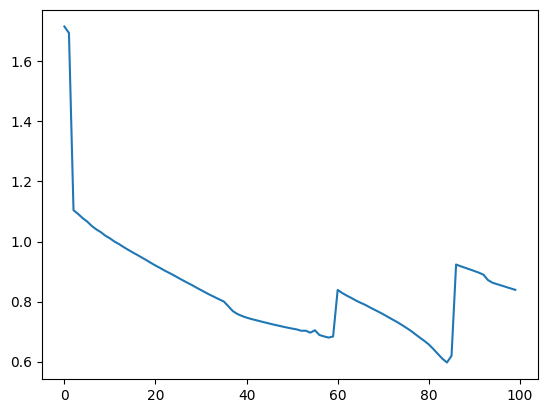

In [48]:
plt.plot(loss_array)
# plt.ylim([1.0, 1.5])

In [49]:
h1 = model3(graph)
arr = h1.numpy()
arr.min(),np.median(arr), arr.max()

(0.5, 0.9996965, 1.0)

In [50]:
with open("graph_rez.json", "w") as f:
    json.dump({"h": h1.numpy().tolist()}, f)


In [51]:
v = graph['nodes_feature']
v=np.array(v)

In [971]:
v

[[186.0, 84.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0],
 [276.0, 84.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0],
 [322.0, 84.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0],
 [345.0, 84.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0],
 [374.0, 84.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0],
 [410.0, 84.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0],
 [444.0, 84.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0],
 [246.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0],
 [293.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0],
 [345.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.0],
 [150.0, 128.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0],
 [204.0, 124.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0],
 [186.0, 128.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0],
 [206.0, 128.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0],
 [229.0, 128.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0],
 [269.0, 124.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0],
 [258.0, 128.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0],
 [275.0, 128.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0],
 [288.0, 128.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0],
 [321.0, 124.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0],
 [309.0, 128.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0],